# STROKE PREDICTION PROJECT

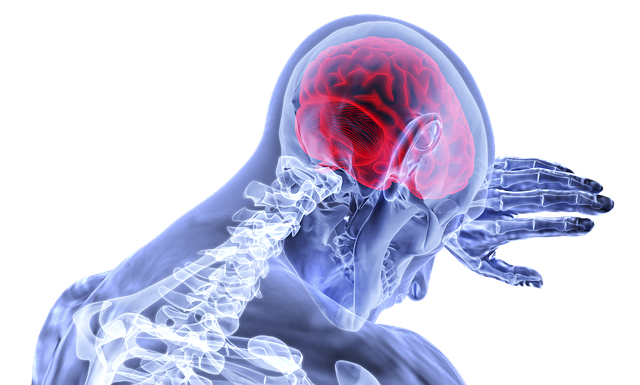

In [2]:
Image('C:/Users/lucas/Documents/MeusProjetos/stroke_prediction/image/stroke.png')

Context:

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Attribute Information:

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

## 0.0. INITIAL

### 0.1. Imports

In [3]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib
from IPython.core.display       import HTML
from IPython.display            import Image
from sklearn                    import model_selection      as ms

### 0.2. Functions

In [4]:
# Função para definição de alguns parâmetros do notebook, como tamanho de gráficos, número de linhas do output, etc.
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.rcParams['font.size'] = 16
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 100
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    sns.set_theme(context = 'notebook', palette = 'Paired')


In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 0.3. Data Load

In [6]:
df_raw = pd.read_csv('C:/Users/lucas/Documents/MeusProjetos/stroke_prediction/data/healthcare-dataset-stroke-data.csv', low_memory = False)

In [7]:
df_raw.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 1.0. DATA DESCRIPTION

In [8]:
df1 = df_raw.copy()

### 1.1. Column's Names

In [9]:
df1.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

### 1.2. Data Dimensions

In [10]:
print('Number of Rows: {}'.format(df1.shape[0]))

print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 5110
Number of Columns: 12


### 1.3. Data Types

In [11]:
# Não se faz necessária a mudança de tipo em nenhuma variável
df1.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### 1.4. Check NA

In [12]:
df1.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [13]:
df1[df1['bmi'].isna() ]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


### 1.5. Replace NA

In [14]:
round(df1['bmi'].mean(), 1)

28.9

In [15]:
# Decidi substituir os valores NA pela média de forma a preservar os outros dados, que são importantes
df1 = df1.fillna(round(df1['bmi'].mean(), 1))

In [16]:
df1.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [17]:
df1.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.9,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [18]:
# Verificação de dados iguais a zero, algumas colunas apresentaram os mesmos porém está de acordo com o esperado
# pois tratam-se de variáveis binárias (0 ou 1)
print("# Linhas no dataframe {0}".format(len(df1)))

for i in range(len(df1.columns)):

    j = df1.columns[i]
    print("# Linhas missing {0} : {1}".format(j, len(df1.loc[df1[j] == 0])))

# Linhas no dataframe 5110
# Linhas missing id : 0
# Linhas missing gender : 0
# Linhas missing age : 0
# Linhas missing hypertension : 4612
# Linhas missing heart_disease : 4834
# Linhas missing ever_married : 0
# Linhas missing work_type : 0
# Linhas missing Residence_type : 0
# Linhas missing avg_glucose_level : 0
# Linhas missing bmi : 0
# Linhas missing smoking_status : 0
# Linhas missing stroke : 4861


### 1.6. Descriptive Statistical

In [19]:
# Dividindo as variáveis em categóricas e numéricas para análise
num_attr = df1.select_dtypes(include = ['int64', 'float64'])
cat_attr = df1.select_dtypes(exclude = ['int64', 'float64'])

#### 1.6.1 Numerical Attributes

In [20]:
# Central Tendency - mean, median 
ct1 = pd.DataFrame(num_attr.apply(np.mean)).T
ct2 = pd.DataFrame(num_attr.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attr.apply(np.std)).T 
d2 = pd.DataFrame(num_attr.apply(min)).T 
d3 = pd.DataFrame(num_attr.apply(max)).T 
d4 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(num_attr.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis())).T 

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,67.00,72940.00,72873.00,36517.829354,36932.000,21159.650905,-0.019913,-1.212368
1,age,0.08,82.00,81.92,43.226614,45.000,22.610434,-0.137059,-0.991010
2,hypertension,0.00,1.00,1.00,0.097456,0.000,0.296578,2.715392,5.375456
3,heart_disease,0.00,1.00,1.00,0.054012,0.000,0.226041,3.947244,13.586052
4,avg_glucose_level,55.12,271.74,216.62,106.147677,91.885,45.279129,1.572284,1.680479
5,bmi,10.30,97.60,87.30,28.893503,28.400,7.697265,1.076612,3.622912
6,stroke,0.00,1.00,1.00,0.048728,0.000,0.215299,4.193284,15.589736


C:\Users\lucas\anaconda3\envs\stroke_prediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas\anaconda3\envs\stroke_prediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas\anaconda3\envs\stroke_prediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

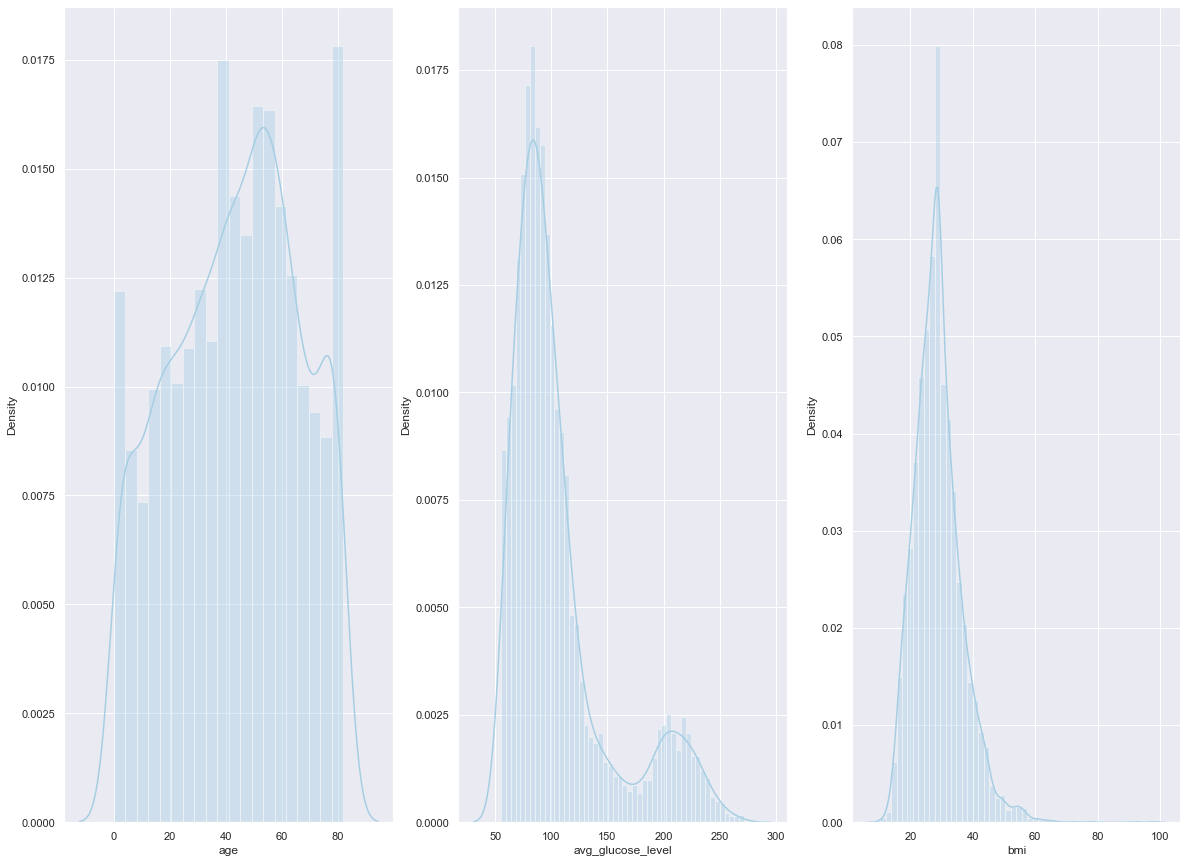

In [21]:
plt.subplot(1, 3, 1)
sns.distplot(df1['age']);

plt.subplot(1, 3, 2)
sns.distplot(df1['avg_glucose_level']);


plt.subplot(1, 3, 3)
sns.distplot(df1['bmi']);

#### 1.6.2 Categorical Attributes

In [22]:
# Discovering how many types each categorical variable has
cat_attr.apply(lambda x: x.unique().shape[0])

gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64

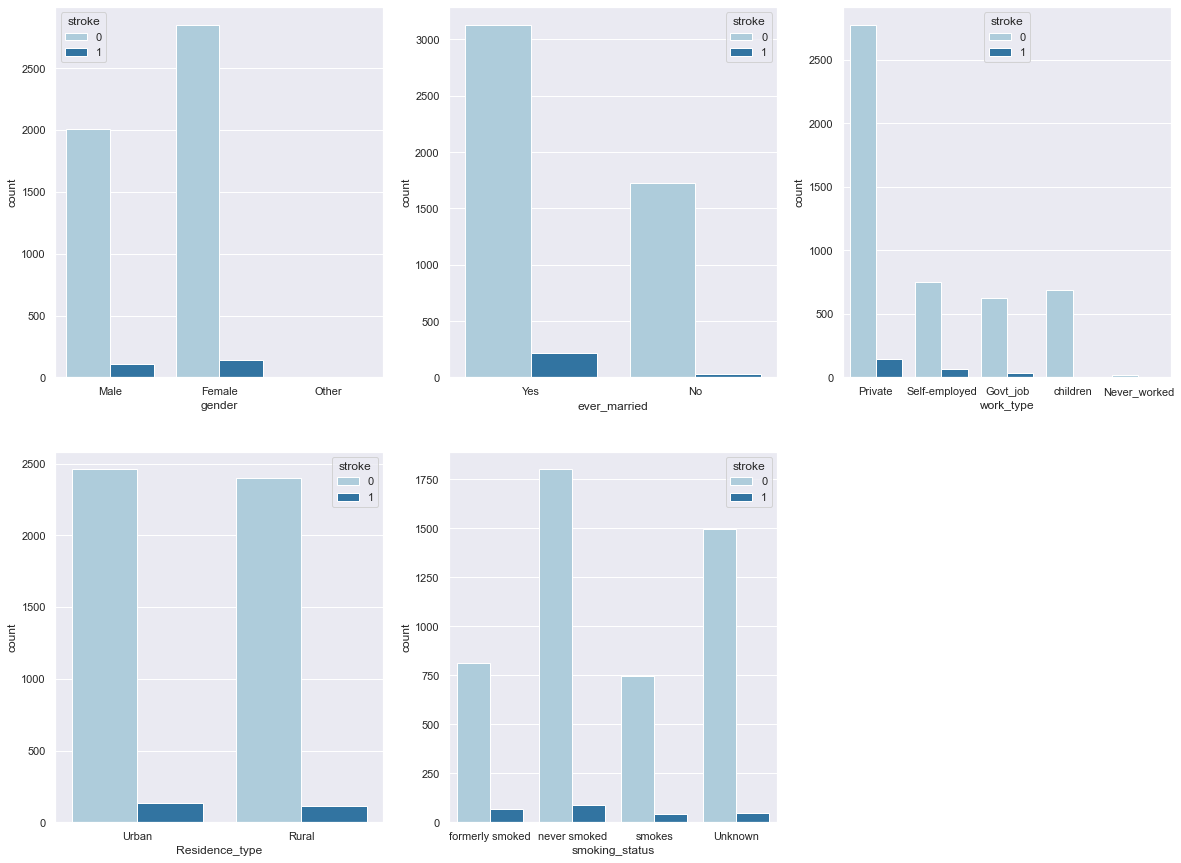

In [23]:
plt.subplot(2, 3, 1)
sns.countplot(data = df1, x = 'gender', hue = 'stroke');

plt.subplot(2, 3, 2)
sns.countplot(data = df1, x = 'ever_married', hue = 'stroke');

plt.subplot(2, 3, 3)
sns.countplot(data = df1, x = 'work_type', hue = 'stroke');

plt.subplot(2, 3, 4)
sns.countplot(data = df1, x = 'Residence_type', hue = 'stroke');

plt.subplot(2, 3, 5)
sns.countplot(data = df1, x = 'smoking_status', hue = 'stroke');

## 2.0. FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

### 2.1. Hypothesis Mind Map

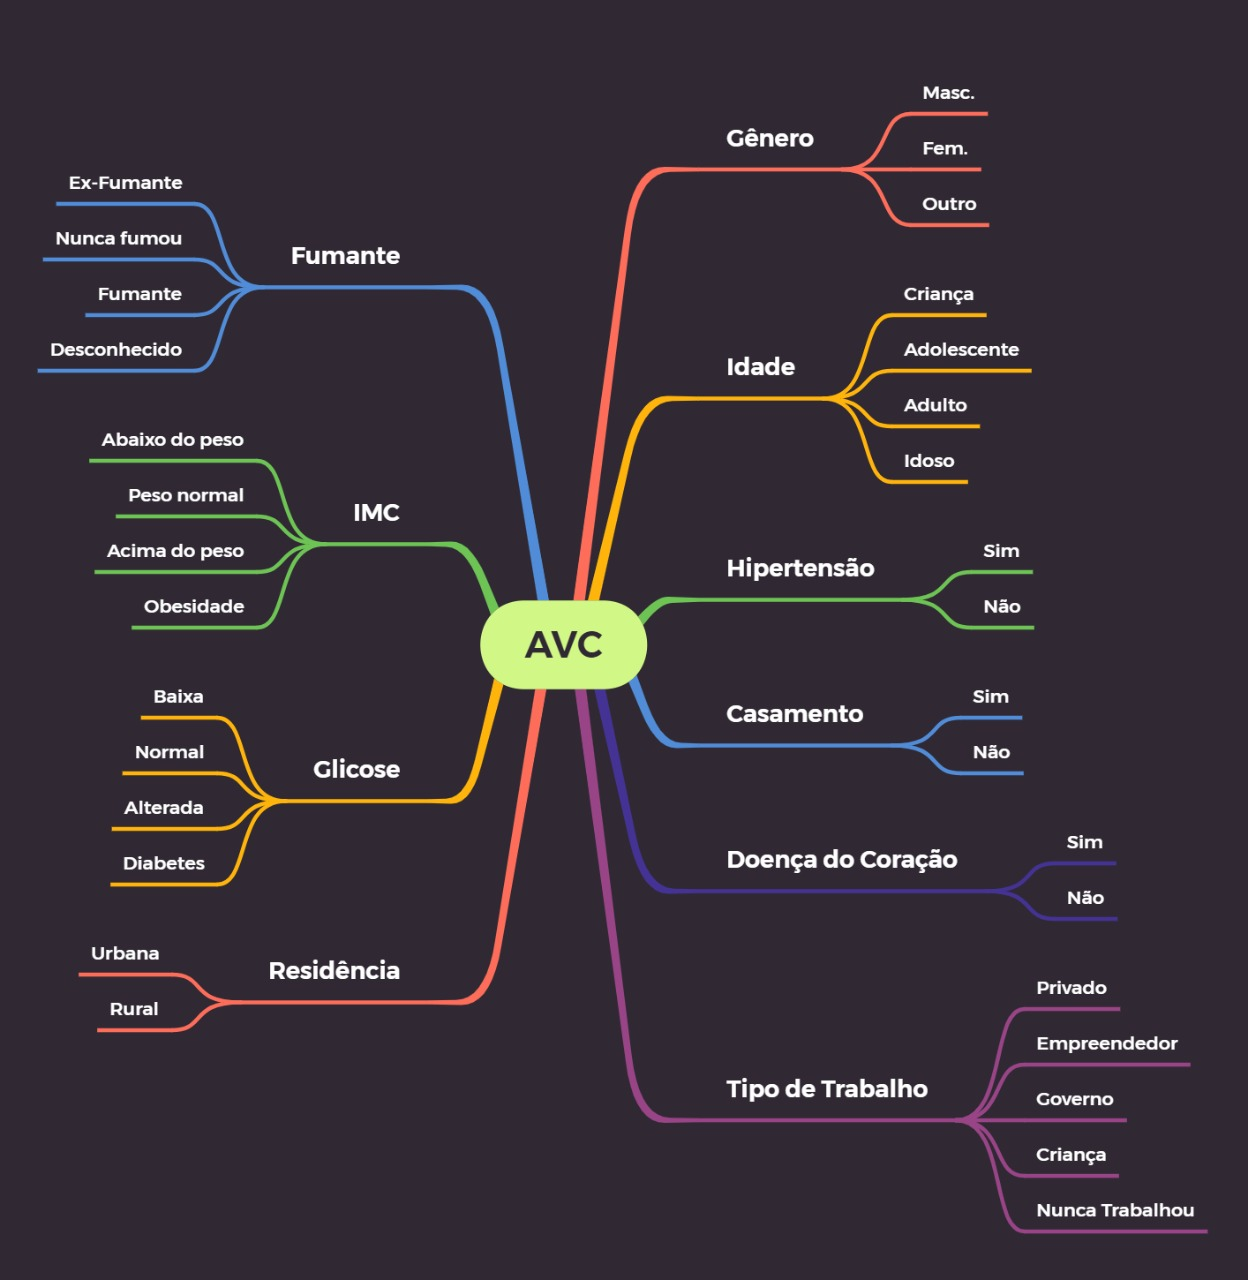

In [25]:
# Mapa mental de hipóteses
Image('C:/Users/lucas/Documents/MeusProjetos/stroke_prediction/image/hmm.jpeg')

### 2.2. Hypothesis Creation

Hipóteses Gênero

1 - Homens têm mais chances de ter AVC que mulheres 

Hipóteses Fumante

1 - Fumantes têm mais chances de ter AVC que os demais

2 - Pessoas que nunca fumaram têm menos chances de ter AVC que os demais

Hipóteses Idade

1 - Crianças têm menos chances de ter AVC que os demais

2 - Idosos têm mais chances de ter AVC que os demais

Hipóteses IMC

1 - Pessoas obesas têm mais chances de ter AVC que os demais

2 - Pessoas com peso normal têm menos chances de ter AVC que os demais

Hipóteses Glicose

1 - Pessoas diabéticas têm mais chances de ter AVC que os demais

2 - Pessoas com glicose normal têm menos chances de ter AVC que os demais

Hipóteses Casamento

1 - Pessoas casadas têm mais chances de ter AVC 

Hipóteses Hipertensão

1 - Pessoas hipertensas têm mais chances de ter AVC

Hipóteses Doença do Coração

1 - Pessoas cardíacas têm mais chances de ter AVC

Hipóteses Residência

1 - Pessoas que moram na zona urbana têm mais chances de ter AVC

Hipóteses Tipo de Trabalho

1 - Pessoas empreendedoras têm mais chances de ter AVC que os demais

2 - Crianças têm menos chances de ter AVC que os demais

### 2.3. Feature Engineering

In [26]:
df2.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.9,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [42]:
# Dividindo o IMC (BMI) em categorias que possibilitem a análise e validação das hipóteses
df2['weight_status'] = df2['bmi'].apply(lambda x: 'underweight'     if      x < 18.5                else
                                                  'normal_weight'   if      (x >= 18.5) & (x <= 24.9)   else
                                                  'overweight'      if      (x > 24.9) & (x < 30)       else
                                                  'obesity')

In [28]:
# Dividindo o nível de glicose em categorias que possibilitem a análise e validação das hipóteses
df2['glucose_status'] = df2['avg_glucose_level'].apply(lambda x: 'low'          if      x <= 70                else
                                                                 'normal'       if      (x > 70) & (x < 100)   else
                                                                 'prediabetes'  if      (x >= 100) & (x <= 125)       else
                                                                 'diabetes')

In [29]:
# Dividindo as idades em categorias que possibilitem a análise e validação das hipóteses
df2['age_group'] = df2['age'].apply(lambda x:   'children'          if      x <= 16                else
                                                'adult'             if      (x > 16) & (x < 60)       else
                                                'elderly')

## 3.0. VARIABLE FILTERING

In [43]:
df3 = df2.copy()

## 4.0. EXPLORATORY DATA ANALYSIS

In [44]:
df4 = df3.copy()

### 4.1. Univariate analysis

#### 4.1.1 Response Variable

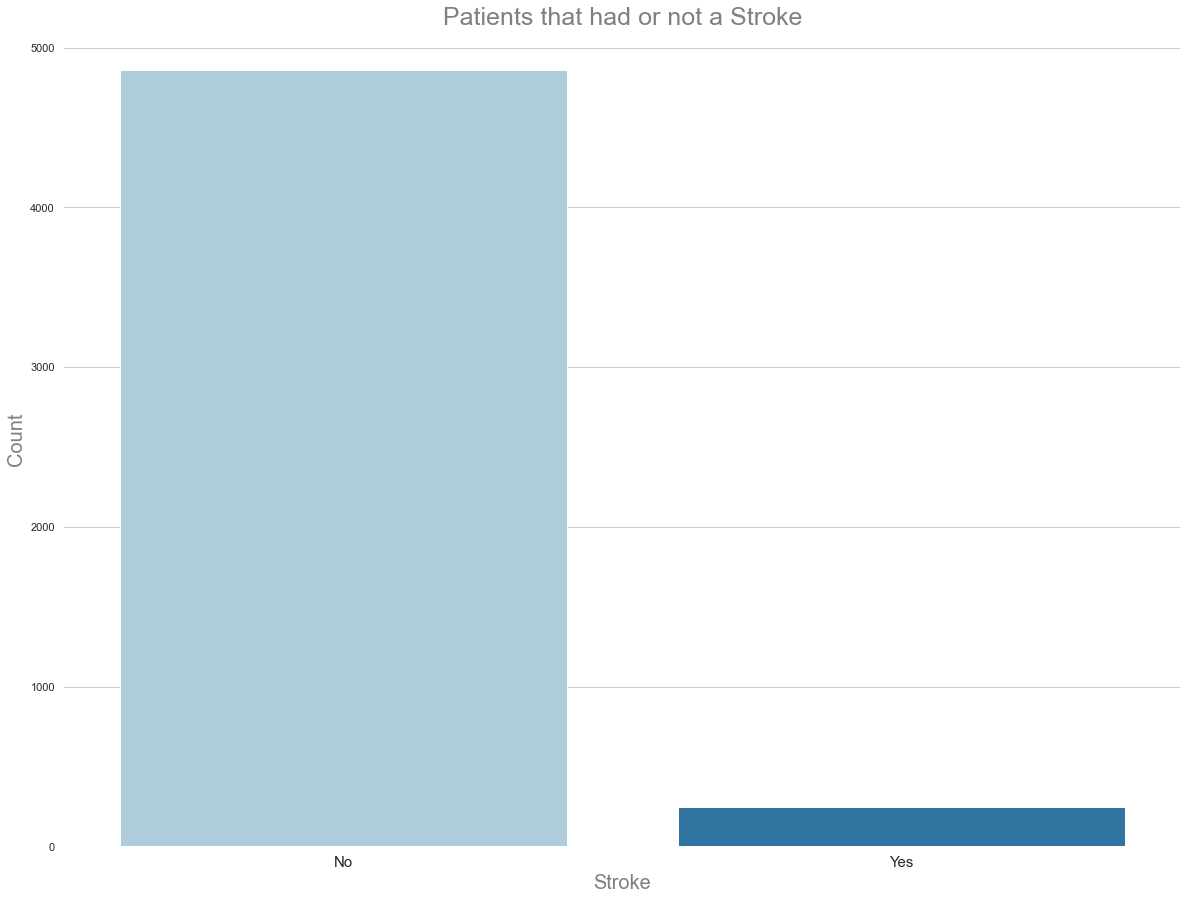

In [111]:
# Percebe-se um significativo desbalanceamento na variável resposta
sns.countplot(data = df4, x = 'stroke');
sns.set_style('whitegrid')
plt.title('Patients that had or not a Stroke', size = 25, color = 'grey')
plt.xlabel('Stroke', size = 20, color = 'grey')
plt.xticks(np.arange(2), labels=['No','Yes'], size = 15)
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.ylabel("Count", size = 20, color = 'grey');

#### 4.1.1 Numerical Variables

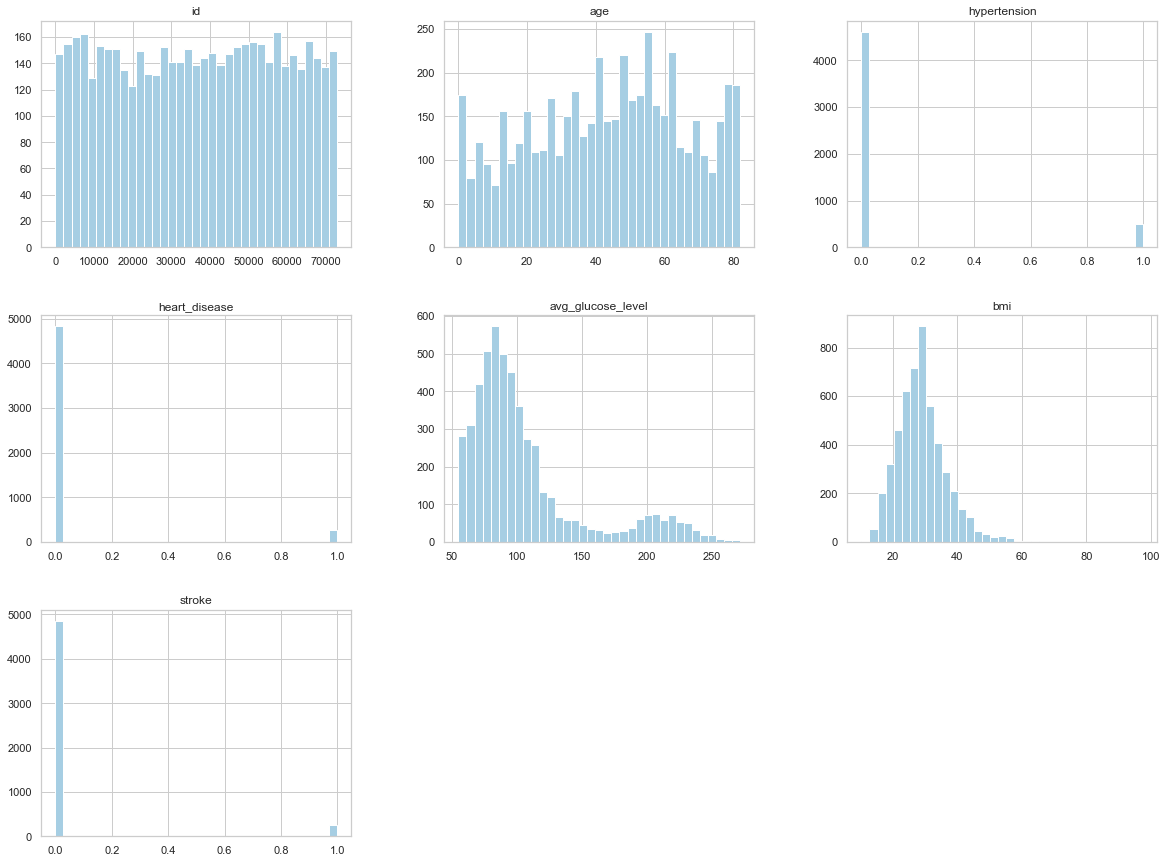

In [94]:
num_attr.hist(bins = 35);

#### 4.1.1 Categorical Variables

<AxesSubplot:xlabel='age_group', ylabel='count'>

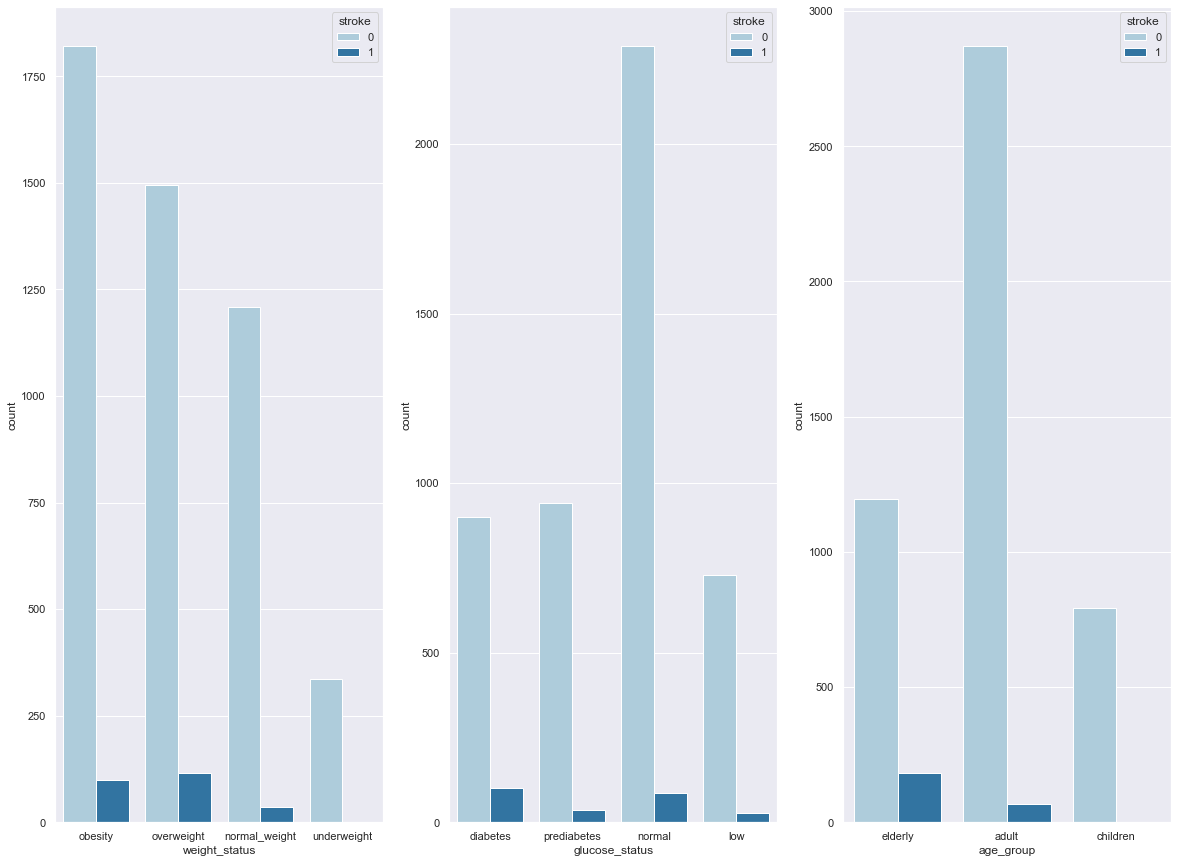

In [59]:
# weight_status
plt.subplot(1, 3, 1)
sns.countplot(data = df4, x = 'weight_status', hue = 'stroke');

# glucose_status
plt.subplot(1, 3, 2)
sns.countplot(data = df4, x = 'glucose_status', hue = 'stroke');

# age_group
plt.subplot(1, 3, 3)
sns.countplot(data = df4, x = 'age_group', hue = 'stroke');


### 4.2. Bivariate analysis - Hypothesis Validation

#### Hipótese 1 - Homens têm mais chances de ter AVC que mulheres 

FALSA - Mulheres tiveram mais AVC que homens

In [109]:
aux = df4[df4['stroke'] == 1][['gender', 'stroke']].groupby('gender').sum().reset_index()
aux

,gender,stroke
0,Female,141
1,Male,108


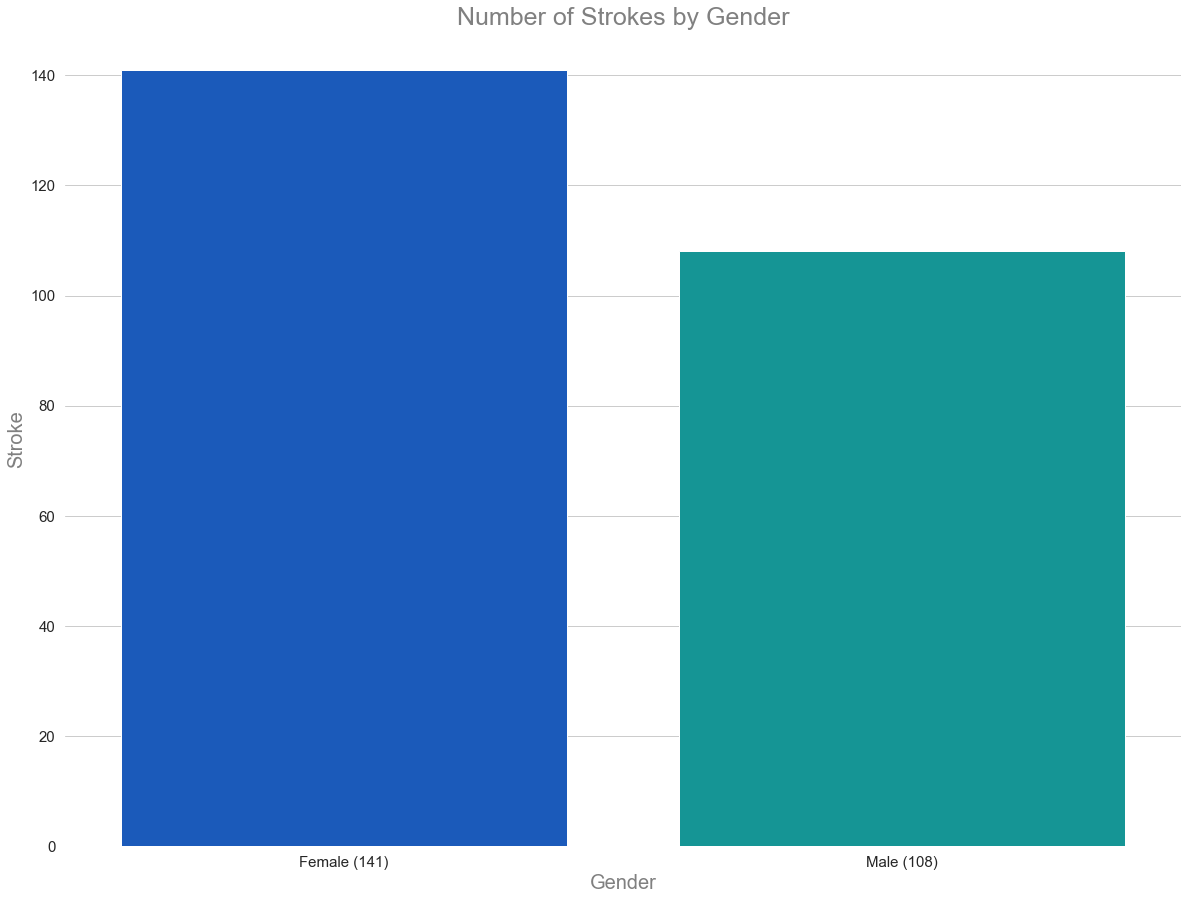

In [115]:
sns.barplot( x = 'gender', y = 'stroke', data = aux, palette = 'winter' );
plt.title('Number of Strokes by Gender', size = 25, color = 'grey')
sns.despine(bottom = True, left = True)
plt.xlabel("Gender", size = 20, color = 'grey')
plt.ylabel("Stroke", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Female (141)', 'Male (108)'], size = 15)
plt.yticks(size = 15);

#### Hipótese 2 - Fumantes têm mais chances de ter AVC que os demais 

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 3 - Pessoas que nunca fumaram têm menos chances de ter AVC que os demais

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 4 - Crianças têm menos chances de ter AVC que os demais 

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 5 - Idosos têm mais chances de ter AVC que os demais

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 6 - Pessoas obesas têm mais chances de ter AVC que os demais

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 7 - Pessoas com peso normal têm menos chances de ter AVC que os demais 

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 8 - Pessoas diabéticas têm mais chances de ter AVC que os demais

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 9 - Pessoas com nível de glicose normal têm menos chances de ter AVC que os demais 

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 10 - Pessoas casadas têm mais chances de ter AVC 

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 11 - Pessoas hipertensas têm mais chances de ter AVC 

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 12 - Pessoas cardíacas têm mais chances de ter AVC 

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 13 - Pessoas que moram na zona urbana têm mais chances de ter AVC 

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 14 - Pessoas empreendedoras têm mais chances de ter AVC que os demais 

FALSA - Mulheres tiveram mais AVC que homens

#### Hipótese 15 - Crianças têm menos chances de ter AVC que os demais 

FALSA - Mulheres tiveram mais AVC que homens

## 7.0. MACHINE LEARNING MODELLING

In [30]:
# x = df2.drop('stroke', axis = 1)
# y = df2['stroke'].copy()

In [31]:
# # Split dataset into training and test
# x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size = 0.3, random_state = 42)
